# ImageNet - Bayesian Optimization 
## 02463 Active ML and Agency - Group BO 2

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

# Download the CIFAR-100 dataset (train and test)
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

# Create data loaders - BATCH SIZE IS SUBJECTIVE TO CHANGE 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

# Check the data
images, labels = next(iter(trainloader))

Files already downloaded and verified
Files already downloaded and verified


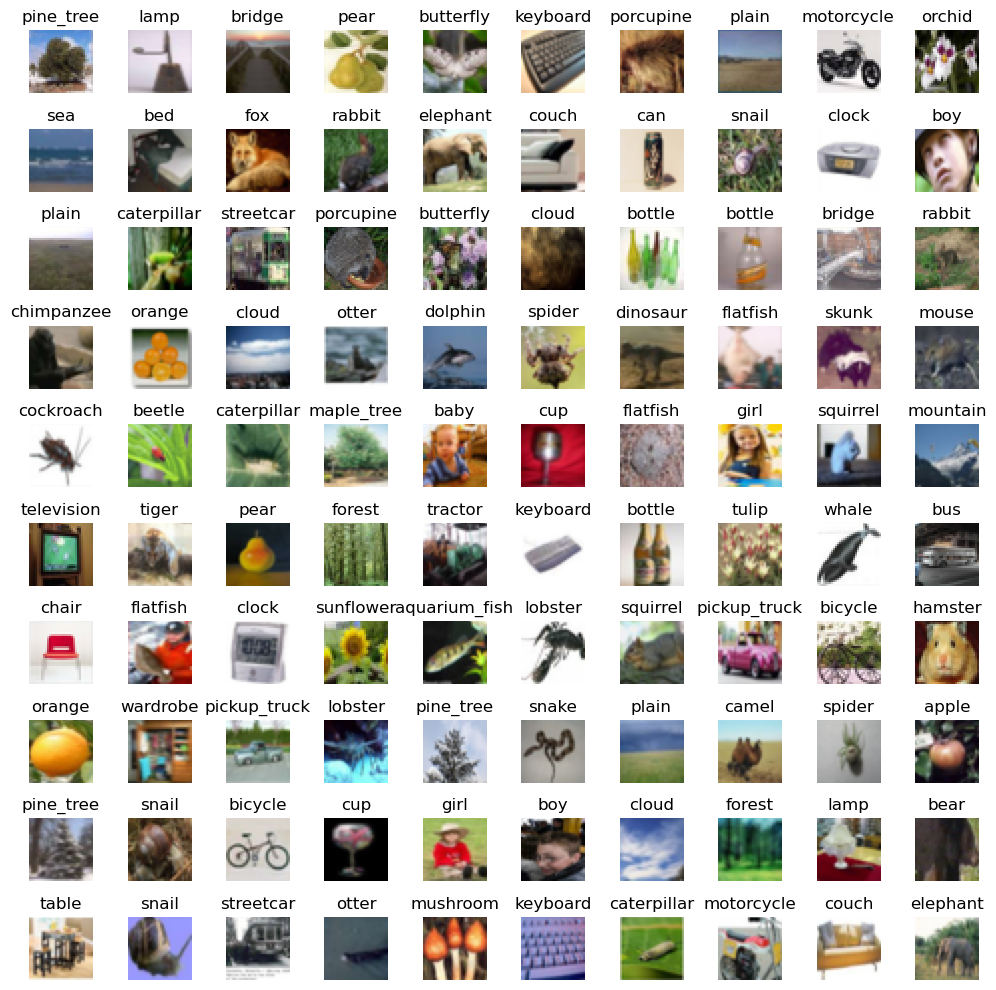

In [ ]:
# Create a 10x10 subplot with random iamges and class mappings to observe our dataset

# Define the fine label names to get descriptive plots
fine_label_names = trainset.classes

fig, axs = plt.subplots(10, 10, figsize=(10, 10))
for i in range(10):
    for j in range(10):
        idx = np.random.randint(0, 10000)
        img, label = trainset[idx]
        img = img / 2 + 0.5
        img = img.numpy().transpose(1, 2, 0)
        axs[i, j].imshow(img)
        axs[i, j].set_title(fine_label_names[label])
        axs[i, j].axis('off')
plt.tight_layout()
plt.show()